In [100]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [101]:
cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [102]:
data = pd.read_csv("../data/SBUX.csv")
print(data.dtypes)

data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace=True)
data["Volume"] = data["Volume"].astype(float)

data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [103]:
x = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
print(x)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [104]:
ms = MinMaxScaler()
ss = StandardScaler()

x_ss = ss.fit_transform(x)
y_ms = ms.fit_transform(y)

x_train = x_ss[:200, :]
x_test = x_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Train Shape: ", x_train.shape, y_train.shape)
print("Test Shape: ", x_test.shape, y_test.shape)

Train Shape:  (200, 5) (200, 1)
Test Shape:  (53, 5) (53, 1)


In [105]:
x_train_tensors = Variable(torch.Tensor(x_train))
x_test_tensors = Variable(torch.Tensor(x_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

x_train_tensors_f = torch.reshape(x_train_tensors, (x_train_tensors.shape[0], 1, x_train_tensors.shape[1]))
x_test_tensors_f = torch.reshape(x_test_tensors, (x_test_tensors.shape[0], 1, x_test_tensors.shape[1]))

print("Training Shape", x_train_tensors.shape, y_train_tensors.shape)
print("Testing Shape", x_test_tensors.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 5]) torch.Size([53, 1])


In [106]:
class BiLSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super().__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device))
        c_0 = Variable(torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device))
        
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        out = self.relu(out)
        return out

In [107]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1

num_classes = 1

model = BiLSTM(num_classes, input_size, hidden_size, num_layers, x_train_tensors_f.shape[1]).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [108]:
for epoch in range(num_epochs):
    outputs = model(x_train_tensors_f.to(device))
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors.to(device))

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print("Epoch: %d, Loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, Loss: 0.04318
Epoch: 100, Loss: 0.03690
Epoch: 200, Loss: 0.03196
Epoch: 300, Loss: 0.02808
Epoch: 400, Loss: 0.02507
Epoch: 500, Loss: 0.02276
Epoch: 600, Loss: 0.02103
Epoch: 700, Loss: 0.01977
Epoch: 800, Loss: 0.01887
Epoch: 900, Loss: 0.01824


In [109]:
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = torch.Tensor(df_x_ss)
df_y_ms = torch.Tensor(df_y_ms)
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

In [110]:
train_predict = model(df_x_ss.to(device))
predicted = train_predict.cpu().data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

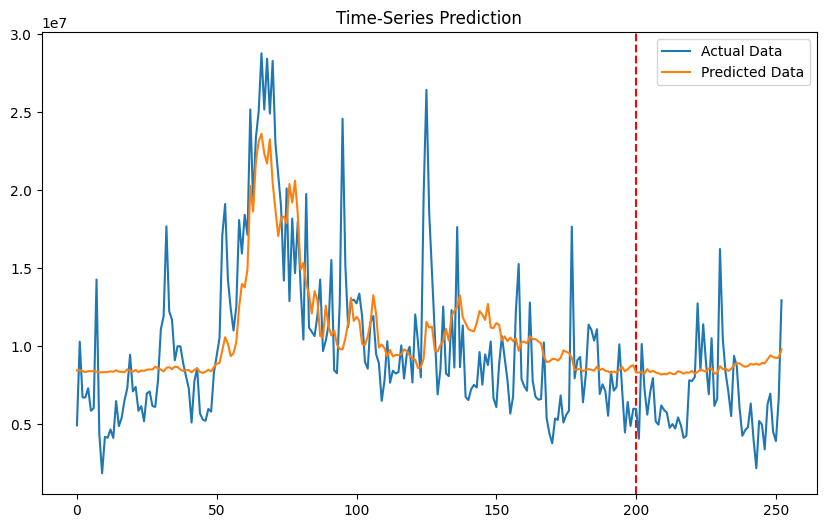

In [111]:
plt.figure(figsize=(10, 6))
plt.axvline(x=200, c="r", linestyle="--")

plt.plot(label_y, label="Actual Data")
plt.plot(predicted, label="Predicted Data")
plt.title("Time-Series Prediction")
plt.legend()
plt.show()